Part of this notebook is based on Franck Iutzeler's course on numerical optimization in Grenoble Alpes University.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from algorithms import *  # Import all methods of the module into the current environment
import logistic_regression_ionosphere as pb  # Import the logistic regression problem object

# Classical optimization algorithms on a Machine Learning problem

We will investigate and display performance of classical optimization algorithms on a practical problem in machine learning: binary classification using logistic regression.

## Machine Learning as an Optimization problem

We have some *data*  $\mathcal{D}$ consisting of $m$ *examples* $\{d_i\}$; each example consisting of a *feature* vector $a_i\in\mathbb{R}^d$ and an *observation* $b_i\in \mathcal{O}$: $\mathcal{D} = \{[a_i,b_i]\}_{i=1..m}$. In this lab, we will consider the <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.names">ionosphere</a> dataset.
 
The goal of *supervised learning* is to construct a predictor for the observations when given feature vectors.

A popular approach is based on *linear models* which are based on finding a *parameter* $x$ such that the real number $\langle a_i , x \rangle$ is used to predict the value of the observation through a *predictor function* $g:\mathbb{R}\to \mathcal{O}$: $g(\langle a_i , x \rangle)$ is the predicted value from $a_i$.

In order to find such a parameter, we use the available data and a *loss* $\ell$ that penalizes the error made between the predicted $g(\langle a_i , x \rangle)$ and observed $b_i$ values. For each example $i$, the corresponding error function for a parameter $x$ is $f_i(x) =   \ell( g(\langle a_i , x \rangle) ; b_i )$. Using the whole data, the parameter that minimizes the total error is the solution of the minimization problem

$$ \min_{x\in\mathbb{R}^d}  \frac{1}{m} \sum_{i=1}^m f_i(x) = \frac{1}{m} \sum_{i=1}^m  \ell( g(\langle a_i , x \rangle) ; b_i ). $$

## Binary Classification with Logisitic Regression

In our setup, the observations are binary: $\mathcal{O} = \{-1 , +1 \}$, and the *Logistic loss* is used to form the following optimization problem
\begin{align*}
\min_{x\in\mathbb{R}^d } f(x) := \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) + \frac{\lambda_2}{2} \|x\|_2^2.
\end{align*}
where the last term $\frac{\lambda_2}{2} \|x\|_2^2$ with hyperparameter `lam2`$=\lambda_2>0$ is added as a regularization (of type $\ell_2$, aka Tikhnov) to prevent overfitting. Adding this term also results in a strongly convex problem.

Under some statistical hypotheses, $x^\star = \arg\min f(x)$ maximizes the likelihood of the labels knowing the features vector. Then, for a new point $d$ with feature vector $a$, 
$$ p_1(a) = \mathbb{P}[d\in \text{ class }  +1] = \frac{1}{1+\exp(-\langle a;x^\star \rangle)} $$

Thus, from $a$, if $p_1(a)$ is close to $1$, one can decide that $d$ belongs to class $1$; and the opposite decision if $p(a)$ is close to $0$. Between the two, the appreciation is left to the data scientist depending on the application.

## Objective of the optimizer
 
Given oracles for the function and its gradient, as well as an upper-bound of the Lipschitz constant $L$ of the gradient, find a minimizer of $f$.
 

> You are given *all* oracles of $f$ (function, gradient, Hessian) in `logistic_regression_ionosphere.py` and several algorithms in `algorithms.py`.

### Constant step size gradient descent

> Fill the update step in `Constant stepsize gradient algorithm` and `Adaptive stepsize gradient algorithm` implementations in `algorithms.py`.

Adding the regularization term $\frac{\lambda_2}{2} \|x\|_2^2$ with hyperparameter `lam2`$=\lambda_2>0$ makes the problem strongly convex whereas if `lam2`$=0$, the problem is only convex. Try running constant gradient descent with `lam2`$=0$ and different positive values of `lam2`. What do you observe? You can also change the step size `step` and observe the different final loss values obtained.

------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 4345 iterations / 5.568431s -- final value: 0.344825


------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 4999 iterations / 6.786498s -- final value: 0.188145


------------------------------------
Adaptative Stepsize gradient
------------------------------------
START    -- stepsize = 0.1
FINISHED -- 4999 iterations / 14.890737s -- final value: 0.170538




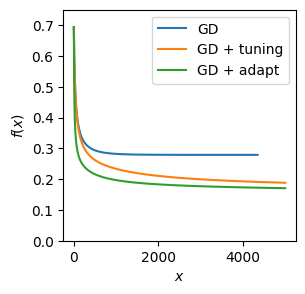

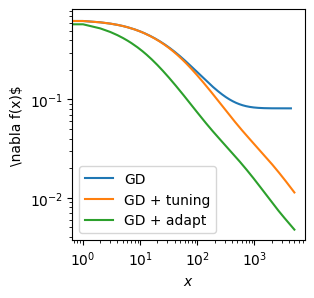

In [2]:
#### Parameters to the gradient descent algorithm
PREC    = 1e-5                     # Sought precision
ITE_MAX = 5000                     # Max number of iterations
x0      = np.zeros(pb.n)           # Initial point
step    = 1.0/pb.L                 # Step size
pb.lam2 = 0.05                     # Regularization term

##### gradient algorithm
x_opt1, x_iterates1 = gradient_algorithm(pb.f, pb.f_grad, x0, step, PREC, ITE_MAX)

# Here you can change the hyperparameter lam2 or the stepsize
step    = 1.0/pb.L                 # Step size
pb.lam2 = 0                        # Regularization term
##### gradient algorithm with different lam2 or step parameter
x_opt2, x_iterates2 = gradient_algorithm(pb.f, pb.f_grad, x0, step, PREC, ITE_MAX)

##### gradient algorithm with adaptive stepsize
x_opt3, x_iterates3 = gradient_adaptive_algorithm(pb.f, pb.f_grad, x0, PREC, ITE_MAX)

compare_loss(pb, 3, [x_iterates1, x_iterates2, x_iterates3], labels = ['GD', 'GD + tuning', 'GD + adapt'])

# Accelerating poorly conditioned problems

While the addition of strong convexity accelerates the rate in practice, it usually results in a shift of the solution of the original problem. For a learning problem, it affects the accuracy.

In order to get faster convergences when the rate is slower, several acceleration techniques exist. We are going to present the most common in the following.

### Nesterov's fast gradient

In a series of papers published in the 80's, Yu. Nesterov proposed an acceleration technique in order to make the worst case rate of the gradient algorithm from $\mathcal{O}(1/k)$ to  $\mathcal{O}(1/k^2)$. This technique is now immensely popular, notably in the machine learning and image processing communities.
 

The iterations of Nesterov's accelerated gradient are as such:
$$ \left\{  \begin{array}{ll}  x_{k+1} = y_k - \gamma \nabla f(y_k) \\ y_{k+1} = x_{k+1} + \alpha_{k+1} (x_{k+1} - x_k )  \end{array}           \right. $$
with 
$$ \alpha_{k+1} = \frac{\lambda_k -1 }{\lambda_{k+1}} \text{ with } \lambda_0 = 0 \text{ and } \lambda_{k+1} = \frac{1+\sqrt{1+4\lambda_k^2}}{2} . $$
 
Although no clear intuition can be drawn, the extended point can be seen as an extension by inertia of the last points.

> Fill the update step in `Nesterov's fast gradient algorithm` implementation in `algorithms.py`.

> Run the constant stepsize and Nesterov's fast gradient algorithms and compare the convergence rates (for lam2 = 0.001).

------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 4999 iterations / 6.475560s -- final value: 0.199636


------------------------------------
 Fast gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 4999 iterations / 6.076007s -- final value: 0.190726




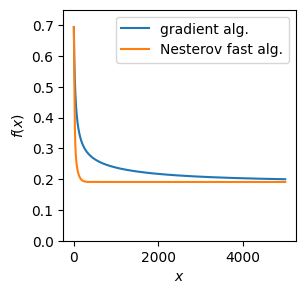

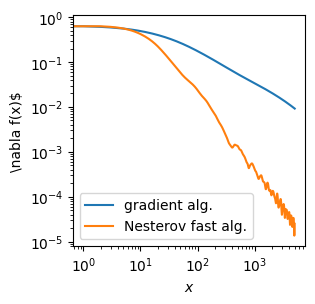

In [3]:
pb.lam2 = 0.001                    # Regularization term (here set to optimal)

##### gradient algorithm
x_opt, x_iterates = gradient_algorithm(pb.f, pb.f_grad, x0, step, PREC, ITE_MAX)

##### Nesterov's fast gradient algorithm
x_opt_fast, x_iterates_fast  = fast_gradient_algorithm(pb.f, pb.f_grad, x0, step, PREC, ITE_MAX)

compare_loss(pb, 2, [x_iterates, x_iterates_fast], labels = ['gradient alg.', 'Nesterov fast alg.'])

### Line-search, BFGS


Other popular methods to accelerate convergence are:
* line-search (as seen quickly in the previous lab, it is implemented in 1.c of file `algoGradient.py`)
* BFGS which is a Quasi-Newton method in the sense that it approximates second order information in an online setting. 

**BFGS.** (Broyden-Fletcher-Goldfarb-Shanno, 1970) The popular BFGS algorithm consist in performing the following iteration
$$ x_{k+1}=x_k - \gamma_k W_k \nabla f(x_k)$$
where $\gamma_k$ is given by Wolfe's line-search and positive definite matrix $W_k$ is computed as
$$ W_{k+1}=W_k - \frac{s_k y_k^T W_k+W_k y_k s_k^T}{y_k^T s_k} +\left[1+\frac{y_k^T W_k y_k}{y_k^T s_k}\right]\frac{s_k s_k^T}{y_k^T s_k} $$
with $s_k=x_{k+1}-x_{k}$ and $y_k=\nabla f(x_{k+1}) - \nabla f(x_{k})$.

> Fill the update step in `Newton algorithm` implementation in `algorithms.py`.

------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 4999 iterations / 6.424372s -- final value: 0.199636


------------------------------------
Newton's algorithm
------------------------------------
START
FINISHED -- 7 iterations / 0.065541s -- final value: 0.190726




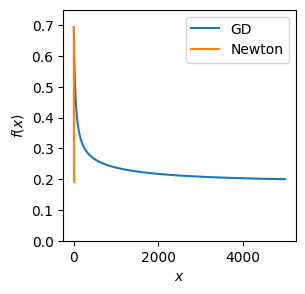

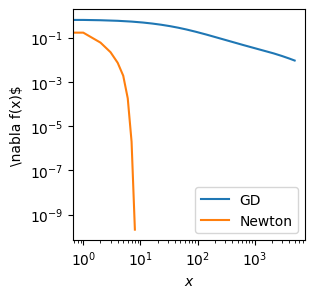

In [4]:
##### gradient algorithm
x_opt, x_iterates = gradient_algorithm(pb.f, pb.f_grad, x0, step, PREC, ITE_MAX)

##### Newton algorithm
x_opt_New, x_iterates_New = newton_algorithm(pb.f, pb.f_grad_hessian, x0, PREC, ITE_MAX )

compare_loss(pb, 2, [x_iterates, x_iterates_New], labels = ['GD', 'Newton'])

> Compare the performance of the previously investigated algorithms. *(Note that you can also test the performance of Newton's method although it is a bit unfair compared to the other algorithms as the variable size is small)*

------------------------------------
 Constant Stepsize gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 4999 iterations / 6.606071s -- final value: 0.199636


------------------------------------
 Fast gradient
------------------------------------
START    -- stepsize = 0.0298918139177214
FINISHED -- 4999 iterations / 5.860290s -- final value: 0.190726


------------------------------------
 Gradient with Wolfe line search
------------------------------------
START
FINISHED -- 366 iterations / 3.018225s -- final value: 0.190726


------------------------------------
 BFGS
------------------------------------
START
FINISHED -- 179 iterations / 0.899975s -- final value: 0.190726




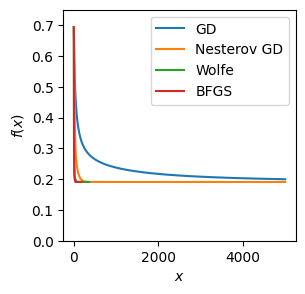

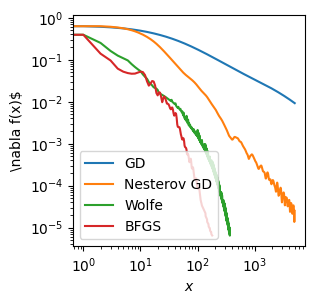

In [5]:
##### gradient algorithm
x_opt, x_iterates = gradient_algorithm(pb.f, pb.f_grad, x0, step, PREC, ITE_MAX)

##### Nesterov's fast gradient algorithm
x_opt_fast, x_iterates_fast  = fast_gradient_algorithm(pb.f, pb.f_grad, x0, step, PREC, ITE_MAX)

##### Wolfe line-search algorithm
x_opt_W, x_iterates_W = gradient_Wolfe(pb.f, pb.f_grad, x0, PREC, ITE_MAX )

##### BFGS algorithm
x_opt_B, x_iterates_B = bfgs(pb.f, pb.f_grad, x0, PREC, ITE_MAX)

compare_loss(pb, 4, [x_iterates, x_iterates_fast, x_iterates_W, x_iterates_B], labels = ['GD', 'Nesterov GD', 'Wolfe', 'BFGS'])

# Performance on learning problems

### Prediction power

Our problem of interest is binary classification using logistic regression.</br>
Although this is a machine learning task, the predictor construction amounts to minimizing a smooth convex optimization function $f$ called the *loss*, the final minimizer is called a *predictor* and its scalar product with the data vector gives a probability of belonging to class $1$.

The previous test was based on the functional decrease whereas our task is binary classification. Let us look at the final accuracies obtained.

> The file `logistic_regression.py` contains a `prediction` function that takes a *predictor* and resturn the accuracy of the predictor. Take a look at how the function is defined.

> Observe the accuracy of all final points obtained before. What do you notice? 

In [8]:
pred, perf = pb.prediction(x_opt, PRINT=False)
print("Gradient algorithm: \t{:.2f}%".format(perf*100))

predF, perfF = pb.prediction(x_opt_fast, PRINT=False)
print("Fast gradient: \t\t{:.2f}%".format(perfF*100))

predW, perfW = pb.prediction(x_opt_W, PRINT=False)
print("Wolfe: \t\t\t{:.2f}%".format(perfW*100))

predB, perfB = pb.prediction(x_opt_B, PRINT=False)
print("BFGS: \t\t\t{:.2f}%".format(perfB*100))

Gradient algorithm: 	92.31%
Fast gradient: 		94.02%
Wolfe: 			94.02%
BFGS: 			94.02%


In [7]:
predF, perfF = pb.prediction(x_opt_fast, PRINT=True)

True class: 1 	-- Predicted: 1 	(confidence: 88.4%)	True
True class: -1 	-- Predicted: -1 	(confidence: 34.2%)	True
True class: 1 	-- Predicted: 1 	(confidence: 94.1%)	True
True class: -1 	-- Predicted: -1 	(confidence: 24.6%)	True
True class: 1 	-- Predicted: 1 	(confidence: 84.5%)	True
True class: -1 	-- Predicted: -1 	(confidence: 9.5%)	True
True class: 1 	-- Predicted: 1 	(confidence: 94.6%)	True
True class: -1 	-- Predicted: -1 	(confidence: 0.0%)	True
True class: 1 	-- Predicted: 1 	(confidence: 97.2%)	True
True class: -1 	-- Predicted: -1 	(confidence: 0.8%)	True
True class: 1 	-- Predicted: 1 	(confidence: 96.0%)	True
True class: -1 	-- Predicted: -1 	(confidence: 60.1%)	True
True class: 1 	-- Predicted: 1 	(confidence: 97.0%)	True
True class: -1 	-- Predicted: 1 	(confidence: 31.3%)	False
True class: 1 	-- Predicted: 1 	(confidence: 91.1%)	True
True class: -1 	-- Predicted: -1 	(confidence: 6.1%)	True
True class: 1 	-- Predicted: 1 	(confidence: 96.1%)	True
True class: -1 	-- 